<a href="https://colab.research.google.com/github/yasuhiroinoue/AppMathSci/blob/main/%E5%BF%9C%E7%94%A8%E6%95%B0%E7%90%86(2021_12_13).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**応用数理科学（第10回）**##
観測データから、数理モデルのパラメータをベイズ推定する方法を学ぶ。

##**Approximated Bayesian Computation (ABC) Sequential Monte Carlo (SMC) method**##

簡単に言えば、パラメータベクトル$\theta$をサンプリングし、シミュレーションによってデータ生成する。とにかくたくさんやる。実験データ$x_0$に近いところに、徐々に絞り込んで、効率よく、$\theta$の事後確率$\pi(\theta|d(x,x_0)\leq ϵ)$を計算する。計算機の力で押し切る。

**解説**

**Approximated Bayesian Computation (ABC)**

$\theta$を推定したいパラメータベクトルとする。事前確率$\pi (\theta)$、データ$x$が与えられたときの$\theta$の尤度関数$f(x|\theta)$として、事後確率は
$$
\pi(\theta|x) \propto f(x|\theta)\pi(\theta)
$$
であり、この事後確率を近似計算する。


1.   提案分布$\pi(\theta)$からパラメータベクトル$\theta^*$をサンプリングする
2.   $\theta^*$を用いてシミュレーションを動かし、データ$x^*$を得る。
3.   シミュレーションデータ$x^*$と実験データ$x_0$から、距離$d(x_0,x^*)$を計算し、$d(x_0,x^*) \leq \epsilon$であれば、$\theta^*$を採用する。1に戻る。

この手続きで、$\pi(\theta|d(x_0,x^*)\leq \epsilon)$が得られる。$ϵ$が十分に小さければ、事後確率の良い近似となる。

ただし、この方法には、事前確率が事後確率と大きく異なっているときに、採択率が低くなる欠点がある（事後確率の近似分布を得るまでに非常に長い計算時間がかかる）。

そこで、Monte Carlo法と組み合わせた方法がいくつか提案されており、本講義ではABC SMCを簡単に紹介する。


**SMC-ABC**

事前確率から、複数のパラメータベクトル値 (粒子と呼ぶ)$\{\theta^{(1)},...,\theta^{(N)}\}$をサンプリングする。
閾値$ϵ$について、$ϵ_1 > \cdots > ϵ_T \geq 0$として、サンプリング初期では、大きめの$ϵ$値を使い採択率を上げることで、パラメータ値の更新が簡単に生じるようにし、次第に小さな値にしていき、事後分布を収束させる。

つまり、初期分布$\pi(\theta)$から中間の分布$\pi(\theta|d(x_0,x*)\leq ϵ_i)$を経由し、最終的に$\pi(\theta|d(x_0,x*)\leq ϵ_T)$から粒子をサンプリングしているとみなせるまで計算を行う。

$\theta$の初期分布$\pi(\theta)$、 $ϵ_1 > \cdots > ϵ_T$、粒子$\{\theta_t^{(i)}\}$ $(i=1,...,N; t=0,...,T)$として、次のアルゴリズムを繰り返す。

1.   $t=0$のとき、$\theta^{**}$を$\pi(\theta)$からサンプリングする<br>$t>0$のとき、まず、前の粒子$\{\theta_{t-1}^{(i)}\}$から重み$w_{t-1}$をもとに、$\theta^*$をサンプリングし、次に、$\theta^{**}$を摂動カーネル$K_t(\theta|\theta^*)$からサンプリングする。もし、$\pi(\theta^{**})=0$であれば、1の最初に戻る。
2.   シミュレーションデータ$x^*$を発生させる。$x^* \sim f(x|\theta^{**})$<br>もし、$d(x^*,x_0)\geq ϵ_t$なら、1の最初に戻る。
3.   $\theta_t^{(i)}=\theta^{**}$とし、$\theta_t^{(i)}$の重みを計算する<br>$$
w_t^{(i)}=\left\{\begin{matrix}
1 & (t=0)\\
\frac{\pi(\theta_t^{(i)})}{\sum_{j=1}^N w_{t-1}^{(j)}K_t(\theta_{t-1}^{(j)},\theta_t^{(i)})} & (t > 0)
\end{matrix}\right.
$$
粒子サンプルについて、$\theta^*$は前の分布から、$\theta^{**}$は摂動後の分布からを表す。$K_t$はランダムウォークになるよう、一様分布かガウス分布が用いられる。



##**ロトカ・ボルテラ方程式**##


In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

In [ ]:
from scipy.integrate import odeint

# ロトカ・ボルテラ方程式

# Definition of parameters
a = 1.0
b = 0.1
c = 1.5
d = 0.75

# initial population of rabbits and foxes
X0 = [10.0, 5.0]
# size of data
size = 100
# time lapse
time = 15
t = np.linspace(0, time, size)

# Lotka - Volterra equation
def dX_dt(X, t, a, b, c, d):
    """ Return the growth rate of fox and rabbit populations. """

    return np.array([a * X[0] - b * X[0] * X[1], -c * X[1] + d * b * X[0] * X[1]])


# simulator function
def competition_model(a, b, c,d):
    return odeint(dX_dt, y0=X0, t=t, rtol=0.01, args=(a, b, c, d))

In [ ]:
# function for generating noisy data to be used as observed data.
def add_noise(a, b, c, d):
    noise = np.random.normal(size=(size, 2))
    simulated = competition_model(a, b, c, d) + noise
    return simulated

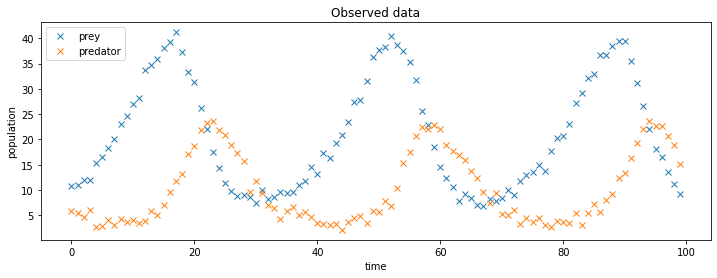

In [ ]:
# plotting observed data.
observed = add_noise(a, b, c, d)
_, ax = plt.subplots(figsize=(12, 4))
ax.plot(observed[:, 0], "x", label="prey")
ax.plot(observed[:, 1], "x", label="predator")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.set_title("Observed data")
ax.legend();

In [ ]:
with pm.Model() as model_lv:
    a = pm.HalfNormal("a", 1.0) ##非負値
    b = pm.HalfNormal("b", 1.0) ##非負値
    c = pm.HalfNormal("c", 1.0) ##非負値
    d = pm.HalfNormal("d", 1.0) ##非負値

    sim = pm.Simulator("sim", competition_model, params=(a, b, c, d), epsilon=10, observed=observed)

    trace_lv = pm.sample_smc(kernel="ABC", parallel=True)
    idata_lv = az.from_pymc3(trace_lv)

Initializing SMC sampler...
Sampling 2 chains in 1 job
Stage:   0 Beta: 0.010
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/pymc3/distributions/simulator.py:146: RuntimeWarning: overflow encountered in square
  return -0.5 * ((obs_data - sim_data) / epsilon) ** 2
Stage:   1 Beta: 0.020
Stage:   2 Beta: 0.031
Stage:   3 Beta: 0.050
Stage:   4 Beta: 0.098
Stage:   5 Beta: 0.215
Stage:   6 Beta: 0.471
Stage:   7 Beta: 1.000
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODE

ここで距離関数$d$は
$$
d(x_0,x_s)=-0.5\left(\frac{x_0 - x_s}{\epsilon} \right)^2
$$
である。（PyMC）

https://docs.pymc.io/en/latest/api/distributions/simulator.html

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe366f86810>,
      dtype=object)

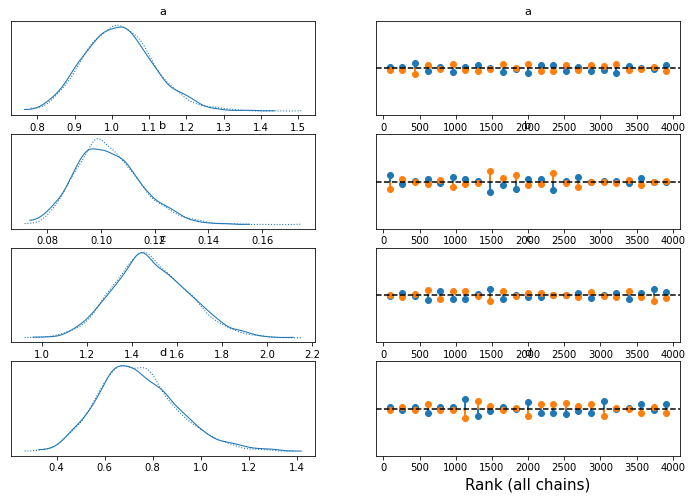

In [ ]:
az.plot_trace(idata_lv, kind="rank_vlines")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe35e4cda50>,
      dtype=object)

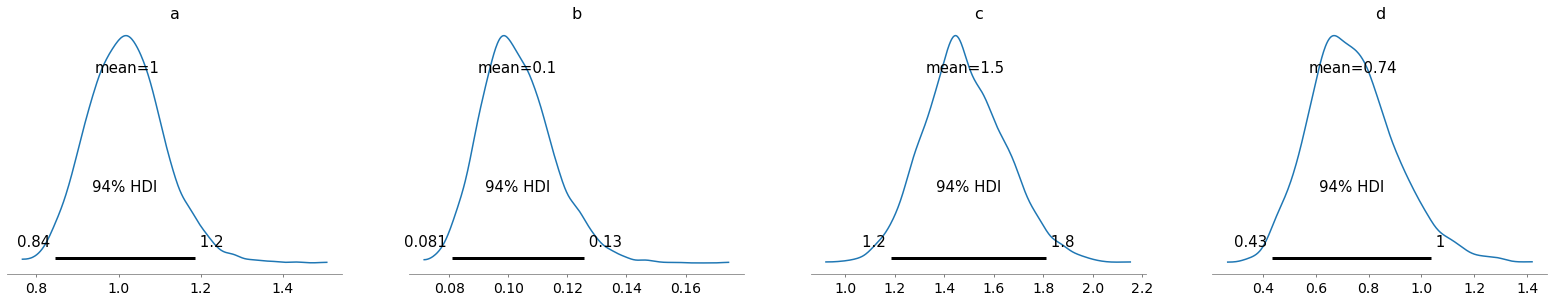

In [ ]:
## Highest density interval (HDI) 区間HDIにある点は、区間外の点よりも必ず確率密度が高い
az.plot_posterior(idata_lv)

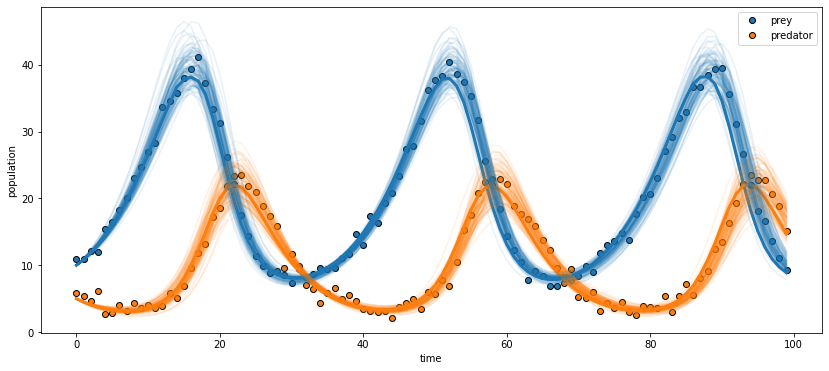

In [ ]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(observed[:, 0], "o", label="prey", c="C0", mec="k")
ax.plot(observed[:, 1], "o", label="predator", c="C1", mec="k")
ax.plot(competition_model(trace_lv["a"].mean(), trace_lv["b"].mean(), trace_lv["c"].mean(), trace_lv["d"].mean()), linewidth=3)
for i in np.random.randint(0, len(trace_lv), 100):
    sim = competition_model(trace_lv["a"][i], trace_lv["b"][i], trace_lv["c"][i], trace_lv["d"][i])
    ax.plot(sim[:, 0], alpha=0.1, c="C0")
    ax.plot(sim[:, 1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

In [ ]:
print("a",trace_lv["a"].mean())
print("b",trace_lv["b"].mean())
print("c",trace_lv["c"].mean())
print("d",trace_lv["d"].mean())

a 1.0202287669513952
b 0.10297665734129562
c 1.483723904051692
d 0.7411676722213122


##**隠れ系の推定**##

第1回講義では、人口動態について、環境収容力を仮定したモデルを導入し、人口飽和へ漸近することを説明した。
しかしながら、日本において、2010年頃以降は人口減少に転じており、一定値への漸近とは異なる傾向を示しているとも考えられる。
そこで、環境収容力の時間変化をモデル化し、人口動態の説明の再考を試みる。

もちろん、環境収容力などというものは測定することはできないので、これは観測から完全に隠れているとみなす。隠れ系（環境収容力）の動態を、観測できる量（人口データ）のみから推定し、観測量を説明する、というのが演習の主旨である。


講義用の演習データは下記からダウンロードできる。<br>
https://www.dropbox.com/s/hwz9gff8rh97yq1/population.csv?dl=1

また、Googleで「日本 人口」と検索すれば、Data Commonsから最新データを取得できるので、そちらを使っても良い。

環境収容力$N_\infty$は定数ではなく、各年$t$の関数$N_\infty(t)$であるとする。その時間変化の方程式として
$$
\frac{dN_\infty}{dt}=aN\left(1-q-\frac{N}{N_\infty} \right)
$$
とする($a \geq 0$)。
このもとで、第1回講義で紹介した人口動態モデルをSMCで実データに当てはめる。$a=0$のとき、第1回講義と同じ方程式となる。
$$
\frac{dN}{dt} = \gamma N \left(1 - \frac{N}{N_\infty} \right)
$$

In [ ]:
import numpy as np #numpy
from scipy.integrate import odeint #odeint
import matplotlib.pyplot as plt #to draw graphs
import pandas as pd

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm

In [ ]:
##1960-70年は傾向が異なるように見えるので、今回は除外する
df_o = pd.read_csv("population.csv",sep=",")
df = df_o.drop(range(10))

In [ ]:
data_x = df["year"].values
data_y = df["pop"].values

In [ ]:
t = np.linspace(0,50,51)
def func(y,t,g,q,a):
  n,no=y
  dndt = [g*n*(1-n/no), a*n*(1-q - n/no) ]
  return dndt

In [ ]:
# simulator function  
def pop_model(g,q,a):
    b=1.35
    n0 = [data_y[0],b*1e+8]
    sol = odeint(func, n0, t, rtol=0.01,args=(g,q,a))
    pop = sol[:,0]
    return pop

In [ ]:
def disp_pop(g,q,a):
    b=1.35
    n0 = [data_y[0],b*1e+8]
    sol = odeint(func, n0, t, rtol=0.01,args=(g,q,a))
    return sol

In [ ]:
with pm.Model() as model_pop:
    g = pm.HalfNormal("g", 0.2) ##非負値
    q = pm.HalfNormal("q", 0.2) ##非負値
    a = pm.HalfNormal("a", 0.1) ##非負値
   # b = pm.HalfNormal("b", 1.0) ##非負値
   
    sim = pm.Simulator("sim", pop_model, params=(g,q,a), epsilon=0.02e+8, observed=data_y)

    trace_pop = pm.sample_smc(kernel="ABC", parallel=True)
    idata_pop = az.from_pymc3(trace_pop)

Initializing SMC sampler...
Sampling 2 chains in 1 job
/usr/local/lib/python3.7/dist-packages/scipy/integrate/odepack.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
Stage:   0 Beta: 0.001
Stage:   1 Beta: 0.005
Stage:   2 Beta: 0.015
Stage:   3 Beta: 0.048
Stage:   4 Beta: 0.140
Stage:   5 Beta: 0.405
Stage:   6 Beta: 1.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe34c8cbc90>,
      dtype=object)

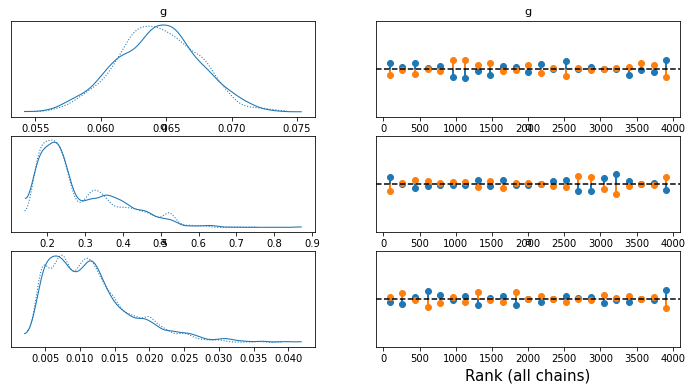

In [ ]:
az.plot_trace(idata_pop, kind="rank_vlines")

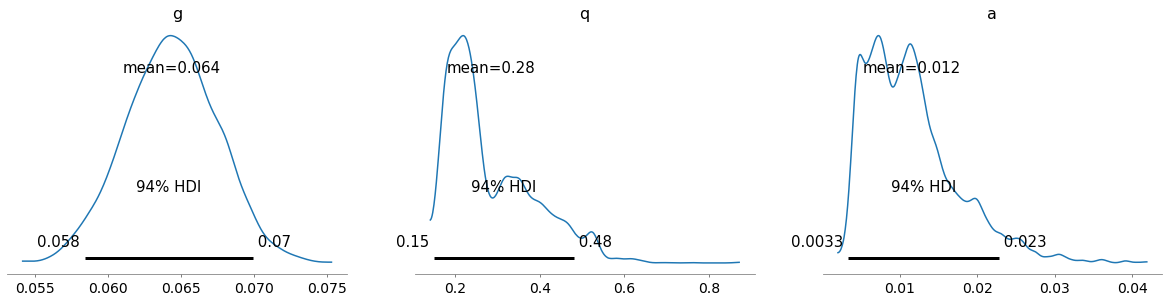

In [ ]:
## Highest density interval (HDI) 区間HDIにある点は、区間外の点よりも必ず確率密度が高い
az.plot_posterior(idata_pop);

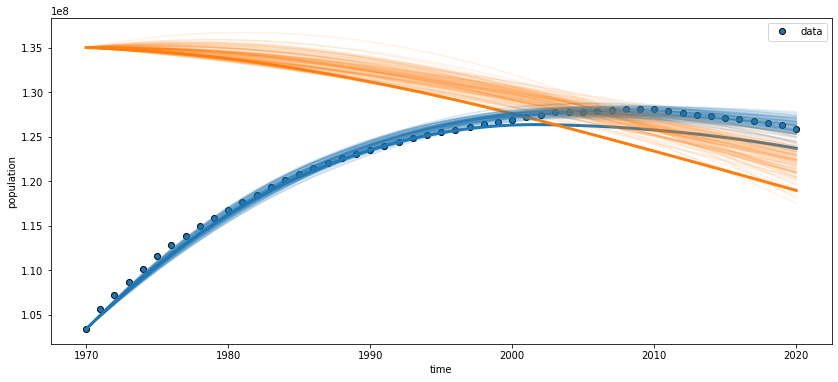

In [ ]:
# plot results
_, ax = plt.subplots(figsize=(14, 6))
ax.plot(data_x,data_y, "o", label="data", c="C0", mec="k")
ax.plot(data_x,disp_pop(trace_pop["g"].mean(),  trace_pop["q"].mean(),  trace_pop["a"].mean()), linewidth=3)
for i in np.random.randint(0, len(trace_pop), 100):
    sim = disp_pop(trace_pop["g"][i], trace_pop["q"][i],  trace_pop["a"][i])
    ax.plot(data_x,sim[:,0], alpha=0.1, c="C0")
    ax.plot(data_x,sim[:,1], alpha=0.1, c="C1")
ax.set_xlabel("time")
ax.set_ylabel("population")
ax.legend();

In [ ]:
print(trace_pop["g"].mean())
print(trace_pop["q"].mean())
print(trace_pop["a"].mean())

0.06437507599611203
0.2834390892784365
0.011504971554540343


##**非線形フィッティング**##

京都の月平均気温の時系列を次の関数形でフィッティングする。
$$
Temp(t) = A\sin(\omega t + \phi) + B_0 + B_1t
$$

$\omega$の値が既知であれば、上式は関数と係数の線形結合$(\sin\omega t, \cos\omega t, 1, t)(A_1,A_2, B_0, B_1)^T$として、最小二乗法により求めることが出来る。しかし、$\omega$も未定係数の場合には、非線形フィッティングを行う必要がある。ここでは、SMCを用いた例と、比較のため局所最適化を避けるBasin-Hopping法を用いた非線形最適化の例を紹介する。

講義用の演習データは下記からダウンロード<br>
https://www.dropbox.com/s/90of8k0gtm0nu0s/kyoto_data.csv?dl=1


最新のデータは、気象庁から直接ダウンロードできるので、それで試しても良いです。<br>
https://www.data.jma.go.jp/gmd/risk/obsdl/index.php

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import pandas as pd
import math

In [ ]:
df_o = pd.read_csv('kyoto_data.csv',encoding='SHIFT-JIS', skiprows=[0,1,2,3,4], names=['ym','temperature','q','f'])

In [ ]:
df=df_o.drop(['q','f'],axis=1)

In [ ]:
df['order']=np.linspace(0,df['ym'].shape[0]-1,df['ym'].shape[0])

In [ ]:
df

,ym,temperature,order
0,1990/11,13.7,0.0
1,1990/12,7.7,1.0
2,1991/1,5.1,2.0
3,1991/2,4.3,3.0
4,1991/3,9.4,4.0
...,...,...,...
368,2021/7,27.9,368.0
369,2021/8,27.7,369.0
370,2021/9,24.6,370.0
371,2021/10,19.6,371.0


In [ ]:
data_x = df.order.values
data_y = df.temperature.values

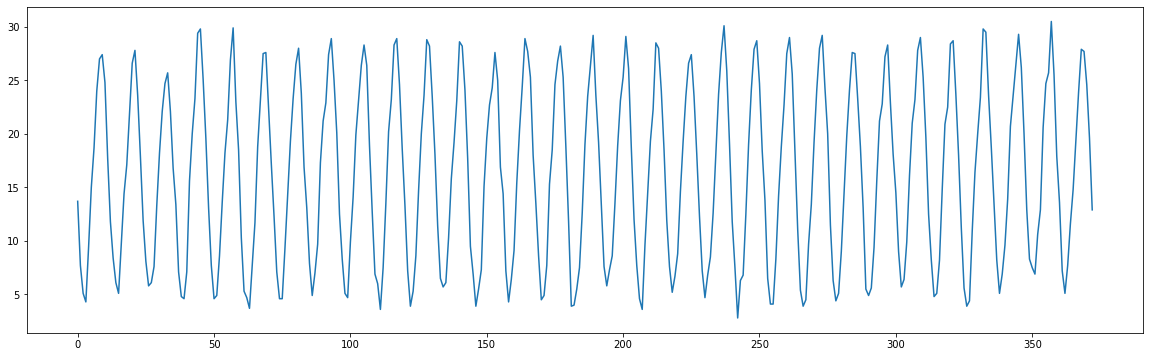

In [ ]:
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_y, label="data", c="C0", mec="k")

周期成分があるので、非線形フィッティングを行う必要がある。
まず、1次多項式による線形フィッティングを行い、直線成分と周期成分に分ける。

In [ ]:
from statsmodels.graphics.api import qqplot
import statsmodels.formula.api as smf
#先に最小二乗法で直線成分だけフィッティングし、あとで周期部分をSMCで決定する
## 1次
res1 = smf.ols('temperature ~ order', data=df).fit()
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:            temperature   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9880
Date:                Sun, 05 Dec 2021   Prob (F-statistic):              0.321
Time:                        12:31:17   Log-Likelihood:                -1315.5
No. Observations:                 373   AIC:                             2635.
Df Residuals:                     371   BIC:                             2643.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     15.4904      0.853     18.161      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


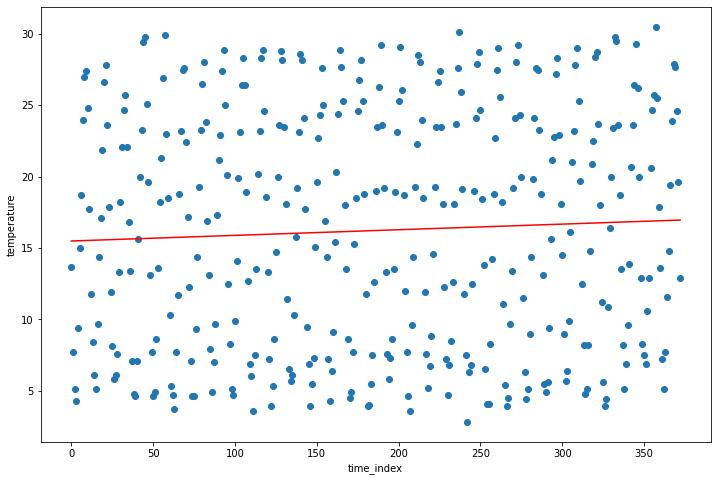

In [ ]:
b0, b1 = res1.params

fig = plt.figure(figsize=(12, 8))
plt.scatter(data_x, data_y)
plt.plot(data_x, b0 + b1*data_x, 'r')
plt.xlabel("time_index")
plt.ylabel("temperature")
plt.show()

In [ ]:
def siny(a,b,c):
  return a*np.sin(b*data_x + c)+b0+b1*data_x

with pm.Model() as model:
    a = pm.HalfNormal("a", 10) ##非負値
    b = pm.HalfNormal("b", 1) ##非負値
    c = pm.Uniform("c",lower=0, upper=2*math.pi)##範囲[0,2pi]

    sim = pm.Simulator("sim", siny, params=(a,b,c), epsilon=5, observed=data_y)

    trace = pm.sample_smc(kernel="ABC", parallel=True)
    idata = az.from_pymc3(trace)

Initializing SMC sampler...
Sampling 2 chains in 1 job
Stage:   0 Beta: 0.006
Stage:   1 Beta: 0.012
Stage:   2 Beta: 0.017
Stage:   3 Beta: 0.023
Stage:   4 Beta: 0.041
Stage:   5 Beta: 0.081
Stage:   6 Beta: 0.205
Stage:   7 Beta: 0.527
Stage:   8 Beta: 1.000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe351d6c350>,
      dtype=object)

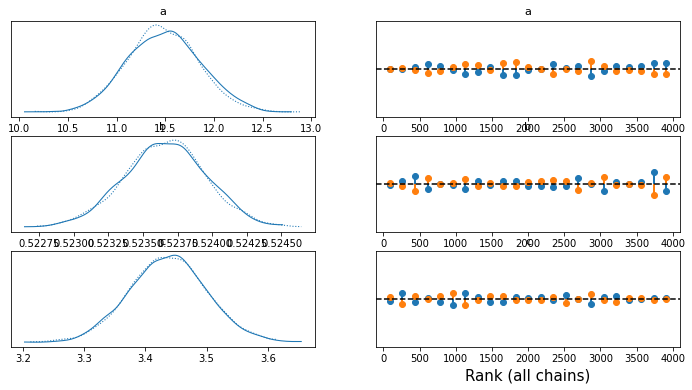

In [ ]:
#2つのchainで、事後確率分布は一致している
#colabのcpuでは、chain数は2になるが、もっと良いマシンを使えば、chain数を増やすことが出来る
az.plot_trace(idata, kind="rank_vlines")

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fe34f350e90>,
      dtype=object)

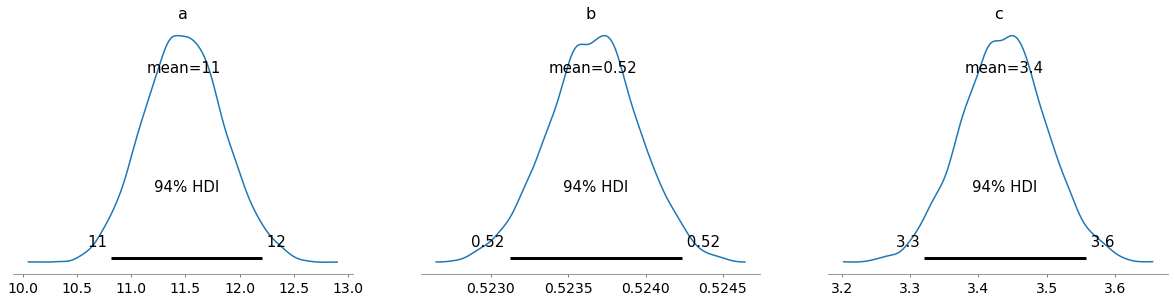

In [ ]:
## Highest density interval (HDI) 区間HDIにある点は、区間外の点よりも必ず確率密度が高い
az.plot_posterior(idata)

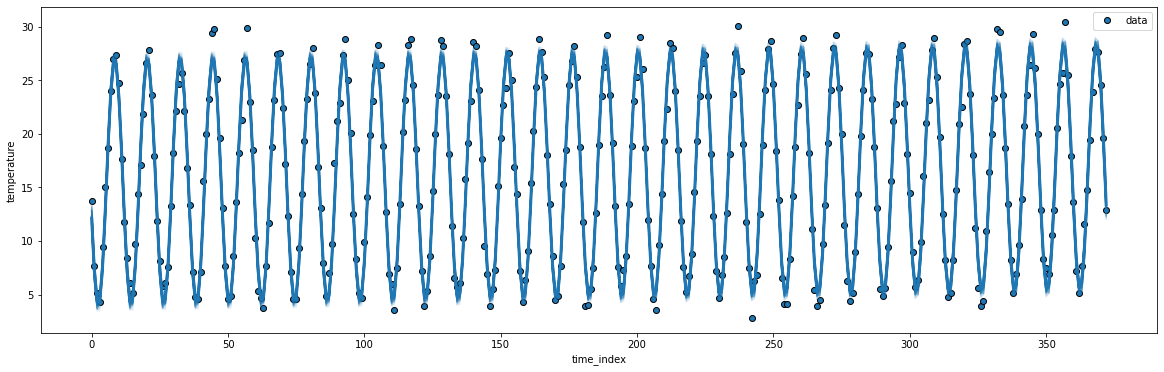

In [ ]:
# plot results
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_y, "o", label="data", c="C0", mec="k")
ax.plot(siny(trace["a"].mean(), trace["b"].mean(), trace["c"].mean()),linewidth=3)
for i in np.random.randint(0, len(trace), 100):
    sim = siny(trace["a"][i], trace["b"][i], trace["c"][i])
    ax.plot(sim, alpha=0.1, c="C0")
ax.set_xlabel("time_index")
ax.set_ylabel("temperature")
ax.legend();

In [ ]:
print("a",trace["a"].mean())
print("b",trace["b"].mean())
print("c",trace["c"].mean())
print("b0",b0)
print("b1",b1)

a 11.482685299494246
b 0.5236596067320002
c 3.4371205792346804
b0 15.490401571303655
b1 0.003944769435609833


###**非線形最適化法 Basin-hoppingとの比較**###

In [ ]:
from scipy.optimize import least_squares
from scipy.optimize import basinhopping

In [ ]:
def y(t,theta):
    return theta[0]*np.sin(theta[1]*t + theta[2])+theta[3]+theta[4]*t

In [ ]:
def calc_residuals(params, data_x, data_y):
    model_y = y(data_x, params)
    return model_y - data_y

In [ ]:
def calc_cost(params, data_x, data_y):
    residuals = calc_residuals(params, data_x, data_y)
    return (residuals * residuals).sum()

In [ ]:
a_init = [1,1,1,1,1]
minimizer_kwargs = {"args":(data_x, data_y)}
#basinhoppingはoptimize.minimize()を呼んでいるので、minimizerのdefaultはBFGS
res = basinhopping(calc_cost, a_init,stepsize=0.5,minimizer_kwargs=minimizer_kwargs,niter=200)

/usr/local/lib/python3.7/dist-packages/scipy/optimize/optimize.py:1058: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


In [ ]:
res

                        fun: 557.5023231236784
 lowest_optimization_result:       fun: 557.5023231236784
 hess_inv: array([[ 2.71474345e-03,  3.18943971e-08, -8.98181658e-06,
        -1.03218350e-04,  4.47211565e-07],
       [ 3.18943971e-08,  1.87838974e-09, -3.63640761e-07,
        -2.32165677e-08,  1.87926018e-10],
       [-8.98181658e-06, -3.63640761e-07,  9.17294317e-05,
         6.27479730e-07, -2.21006742e-08],
       [-1.03218350e-04, -2.32165677e-08,  6.27479730e-07,
         5.43735732e-03, -2.15826219e-05],
       [ 4.47211565e-07,  1.87926018e-10, -2.21006742e-08,
        -2.15826219e-05,  1.15866888e-07]])
      jac: array([-6.33239746e-04,  2.12900543e+00, -1.77307129e-02,  8.62121582e-04,
        9.52758789e-02])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 507
      nit: 17
     njev: 71
   status: 2
  success: False
        x: array([-1.15275550e+01,  5.23657370e-01, -2.48371403e+01,  1.58271852e+01,
        2.18627962e-03])
   

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  func(*args, **kwargs)


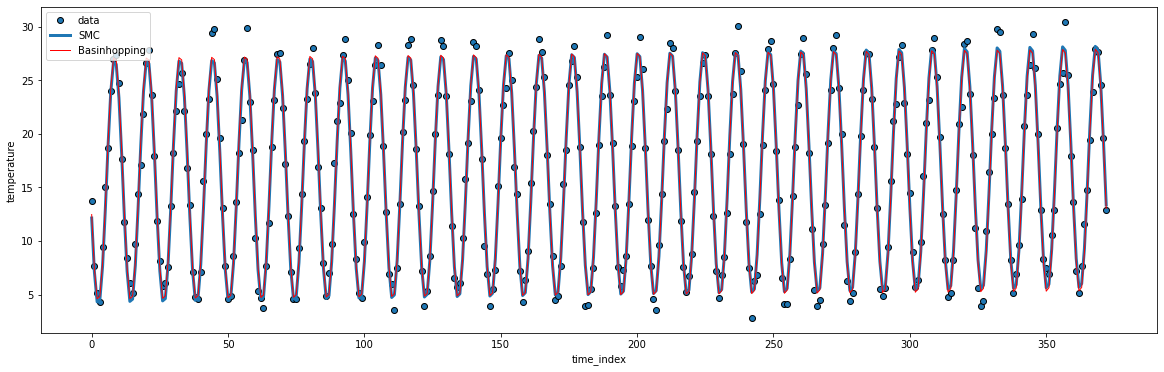

In [ ]:
a_fit = res.x
ys_fit = y(data_x,a_fit)

# plot results
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(data_y, "o", label="data", c="C0", mec="k")
ax.plot(siny(trace["a"].mean(), trace["b"].mean(), trace["c"].mean()), label="SMC", linewidth=3)
ax.plot(ys_fit,label="Basinhopping", c="R",linewidth=1)

ax.set_xlabel("time_index")
ax.set_ylabel("temperature")
ax.legend();

In [ ]:
res.x

array([-1.15275550e+01,  5.23657370e-01, -2.48371403e+01,  1.58271852e+01,
        2.18627962e-03])

In [ ]:
#AICの計算
def aic(n,x,sigma2):
  k=x.shape[0]#モデル自由度
  k+=1#分散も推定値になるので自由度1を足しておく
  return n*math.log(sigma2)+2*k + n + n*math.log(2.*math.pi)

n=len(data_x)
sigma2=res.lowest_optimization_result.fun/n

AIC=aic(n,res.x,sigma2)
print("AIC=",AIC)

AIC= 1220.4324632891578
